# EMit - Emotions in Italian
## Emotion and Target detection
### Emanuele Muzio - 0766230
Il presente notebook rappresenta un'illustrazione dello svolgimento dei due task del contest EMit (Emotions in Italian):
- il primo task, o Task A, è mirato alla classificazione dei sentimenti espressi dai messaggi sui social media riguardanti i prodotti RAI
- il secondo task, o Task B, è mirato alla classificazione del target del messaggio, se sul topic o sulla direzione
Entrambi i task sono classificazione multiclasse e multilabel (nel Task A abbiamo 8 emozioni di base, più _Love_, nel Task B il target può essere uno dei due, entrambi o nessuno).

Ai fini della valutazione dei due task, sono stati forniti dei dataset da utilizzare sia per l'addestramento che per i test, comprensivi di annotazioni.

In [1]:
from transformers import AutoTokenizer, BertModel
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil, sys
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix as mcm, classification_report

#Import torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim import Adam

# Gestione delle emoji
import emot as emot_imp
emot = emot_imp.core.emot()

# TODO: preprocessing (eliminazione di stopword e keyword X, eliminazione hashtag, eliminazione link esterni, eliminazione menzioni) 
# TODO: valutare: lowercase del testo, rimozione punteggiatura
# TODO: tokenizzazione 
# TODO: classificazione tramite modello neurale pytorch

## Task A: Emotion detection
Per il primo task, procediamo in due step, partendo dal preprocessing del testo (principalmente pulizia dei messaggi) per poi andare alla classificazione.

Per la tokenizzazione del testo e la generazione degli embeddings da usare come input al modello neurale, è stato scelto un modello multilingua (dal momento che i messaggi riguardano un'emittente italiana) case-sensitive. 

Il supporto alle emoji/emoticons è stato aggiunto rilevando quelle presenti nel testo e facendo un resize del modello per poterle gestire.

Il modello BERT-like da HuggingFace utilizzato è il seguente: _bert-base-multilingual-cased_.
Elenco delle librerie speciali utilizzate in questa fase:
- nltk per il recupero delle stopwords italiane da rimuovere
- emot per la gestione delle emoji/emoticons

### Task A: Preprocessing
Al fine di valutare soltanto le parti più importanti dei messaggi, con un contributo semantico più corposo, sono state prese diverse decisioni:
- Eliminazione delle menzioni degli utenti (nomi utenti già oscurati nel dataset utilizzato)
- Eliminazione delle stopword da NLTK
- Eliminazione delle keyword legate a X (RT per i retweet e FAV per i messaggi preferiti)
- Eliminazione link esterni
- Eliminazione hashtag
Per quest'ultima fase in particolare, la scelta è stata presa dopo una veloce analisi degli hashtag più frequenti, scelta che verrà motivata a breve.

In [2]:
data = pd.read_csv("release\emit_2023-v1\emit_train_A.csv")
text = data["text"]
emotions = data.drop(["id","text"], axis=1)
model_name = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
nltk.download('stopwords')
stopwords_it = stopwords.words('italian')
X_keywords = ['RT', 'FAV']
checkpoint_fpath = '.'
classes = list(data.columns[2:])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emanu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Funzione che raccoglie i principali 4 controlli che vengono effettuati sul testo, ovvero: 
# - presenza di menzioni ad altri utenti
# - presenza di collegamenti esterni
# - presenza di keyword relative a X (RT, FAV, quest'ultima non presente nei nostri dati)
# - presenza di stop-words in lingua italiana dalla lista fornita dal NaturalLanguageToolKit

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        if t.startswith('@') and len(t) > 1 or t.startswith('http') or t in X_keywords or t.lower() in stopwords_it:
            continue
        else:
            new_text.append(t)
    return " ".join(new_text)

def getHashtags(text):
    hashtags = []
    for t in text.split(" "):
        if t.startswith('#') and len(t) > 1:
            hashtags.append(t)
        else:
            continue
    return hashtags

def removeHashTags(text):
    new_text = []
    for t in text.split(" "):
        if t.startswith('#') and len(t) > 1:
            continue
        else:
            new_text.append(t)
    return " ".join(new_text)

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [4]:
data.isna().sum()

id              0
text            0
Anger           0
Anticipation    0
Disgust         0
Fear            0
Joy             0
Love            0
Neutral         0
Sadness         0
Surprise        0
Trust           0
dtype: int64

<BarContainer object of 10 artists>

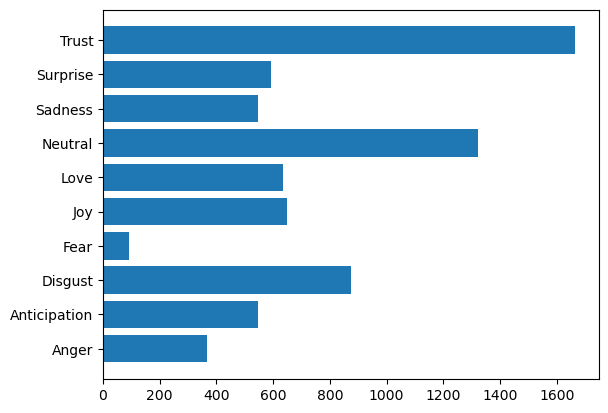

In [5]:
plt.barh(emotions.columns, [emotions[column].sum() for column in emotions.columns])

Non è necessario fare imputazione in quanto non ci sono dati mancanti all'interno del dataset di addestramento.

Possiamo adesso procedere alla pulizia del testo, elemento centrale della nostra indagine.

In [6]:
text = text.apply(preprocess)

Dopo un primo passo di preprocessing del testo, è sorto un dubbio riguardante l'utilità degli hashtag e la conseguente decisione sul mantenerli o meno. 
La scelta finale è stata quella di rimuoverli, dal momento che gli hashtag più diffusi almeno in questa prima fase non aggiungono valore al testo essendo relativi al topic (generalmente il nome del programma televisivo interessato).

Potrebbe essere interessante mantenere queste informazioni per fare uno studio di sentiment analysis differenziata per singolo programma televisivo, tuttavia non è il focus principale del progetto.

Sono stati rilevati in totale 1126 hashtag unici su 5990 totali, con una distribuzione sbilanciata fortemente verso i 20-30 circa più usati, che sono risultati essere hashtag relativi appunto al nome della trasmissione televisiva oggetto del testo.

In [7]:
hashtag_list = list(map(getHashtags, text))
hashtags = []

for h in hashtag_list:
    hashtags.extend(h)

hashtags = list(sorted(hashtags))
unique_hashtags = list(set(hashtags))
hasht_count = [hashtags.count(h) for h in unique_hashtags]

sorted_h = [x for _, x in sorted(zip(hasht_count, unique_hashtags), reverse=True)]
sorted_h_c = list(sorted(hasht_count,reverse=True))

<BarContainer object of 25 artists>

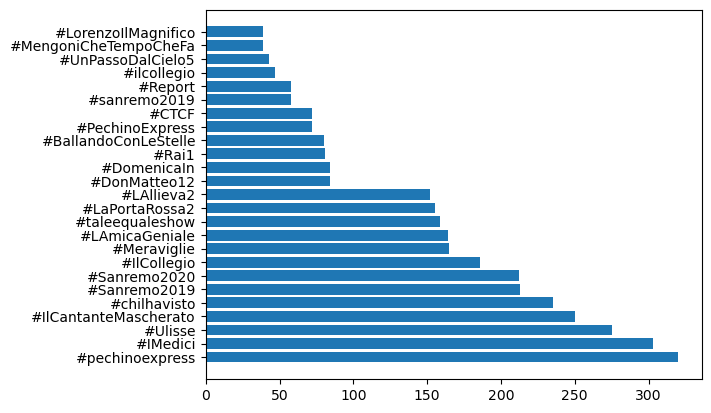

In [8]:
plt.barh(sorted_h[:25], sorted_h_c[:25])

In [9]:
text = text.apply(removeHashTags)

In [10]:
text.head()

0                   Serve aggiungere altro? INIZIA ORA
1    differenza studiato donna forte indipendente m...
2            Metà sobrietà dovrebbe essere distribuita
3                   LENÙ PIACERE SCAPPA ANSIA TE PREGO
4                         Nooooo!!! signora Cecchini 😢
Name: text, dtype: object

Prima di procedere alla classificazione vera e propria, dobbiamo adattare il tokenizer alla presenza delle emoji nel testo, elemento importante per l'interpretazione del testo.

Facciamo quindi una ricerca di emoji ed emoticons presenti e aggiungiamole al tokenizer tramite la funzione add_tokens(), per poi fare un resize del modello e completare questo step.

In [11]:
bulk_emoji = emot.bulk_emoji(text)

unique_emoji = []

for i in range(len(bulk_emoji)):
    res = bulk_emoji[i]
    if res['flag']:
        unique_emoji.extend(res['value'])

unique_emoji = list(set(unique_emoji))

emoji_to_add = set(unique_emoji) - set(tokenizer.vocab.keys())

In [12]:
bulk_emoticons = emot.bulk_emoticons(text)

unique_emoticons = []

for i in range(len(bulk_emoticons)):
    res = bulk_emoticons[i]
    if res['flag']:
        unique_emoticons.extend(res['value'])

unique_emoticons = list(set(unique_emoticons))

emoticons_to_add = set(unique_emoticons) - set(tokenizer.vocab.keys())

In [13]:
new_tokens = []
new_tokens.extend(emoji_to_add)
new_tokens.extend(emoticons_to_add)

In [14]:
print(f"Adding: {len(new_tokens)} emoji/emoticons")

Adding: 261 emoji/emoticons


In [15]:
tokenizer.add_tokens(list(new_tokens))
model.resize_token_embeddings(len(tokenizer))

Embedding(119808, 768)

Durante le prove è emerso che alcuni messaggi sono composti soltanto da menzioni o semplici hashtag, per cui facciamo una veloce pulizia prima di procedere (al contrario, alcuni messaggi non verrebbero processati dal tokenizer, causando degli errori)

In [16]:
for i in range(len(text)):
    if(len(text[i]) == 0):
        text.drop(i, axis=0, inplace=True)
        emotions.drop(i, axis=0, inplace=True)

Vediamo adesso di stabilire brevemente una lunghezza massima in parole dei messaggi.

Possiamo vedere come la stragrande maggioranza dei messaggi abbia una lunghezza inferiore a 25-30 parole, per cui useremo 30 come tetto massimo.

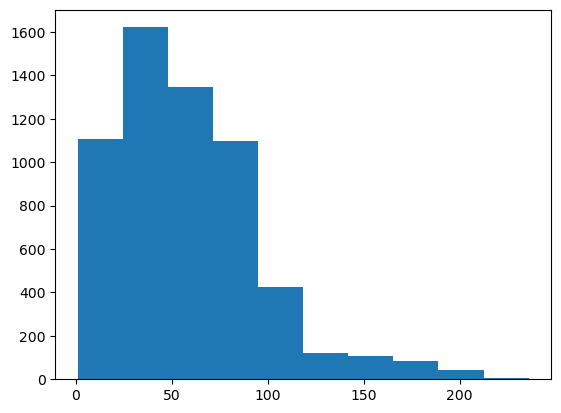

In [17]:
plt.hist([len(t) for t in text])
MAX_LEN = 30

## Task A: Classificazione

Arrivati a questo punto, dobbiamo per prima cosa addestrare il nostro classificatore per il task che dovrà svolgere.

Procediamo a passare tutti i dati etichettati al nostro classificatore 

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [19]:
hyperparameters = {
    'model_name' : model_name,
    'dropout' : 0.2,
    'train_batch_size' : 16,
    'epochs' : 30,
    'lr' : 1e-06,
    'max_len' : MAX_LEN,
    'num_classes' : 10,
    'h_dim' : 768
}

In [36]:
class _Dataset(Dataset):
    def __init__(self, inputs, labels, tokenizer, MAX_LEN, transform=None):
        self.transform = transform
        self.inputs = inputs
        self.labels = labels           
        self.tokenizer = tokenizer
        self.MAX_LEN = MAX_LEN
      
    def __len__(self):
        return len(self.labels)       

    def __getitem__(self, idx):
        inputs = tokenizer(self.inputs[idx], add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = self.MAX_LEN, truncation=True) 
        labels = self.labels.iloc[idx]
        return {
            'ids': inputs['input_ids'],
            'mask': inputs['attention_mask'],
            'token_type_ids': inputs['token_type_ids'],
            'labels': labels
        } 

In [37]:
class BTEClassifier(nn.Module):
    def __init__(self, hyperparameters, model_name):
        super(BTEClassifier, self).__init__()
        self.bte = BertModel.from_pretrained(model_name) # Blocco BTE - Bidirectional Transformer Encoder
        self.classifier = nn.Sequential(
            nn.Dropout(hyperparameters['dropout']), # Layer di dropout,
            nn.Linear(768, hyperparameters['num_classes']), # Layer dense su cui fare fine tuning
            nn.Sigmoid()
        )

    def forward(self, ids, mask, token_type_ids):
        output = self.bte(ids, attention_mask = mask, token_type_ids = token_type_ids).last_hidden_state
        output = output[:,0,:]
        output = self.classifier(output)
        return output

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(text, emotions, test_size=0.2)
train_dataset = _Dataset(X_train, Y_train, tokenizer, hyperparameters['max_len'])
val_dataset = _Dataset(X_test, Y_test, tokenizer, hyperparameters['max_len'])

In [39]:
classifier = BTEClassifier(hyperparameters, model_name)
classifier.to(device)

BTEClassifier(
  (bte): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [52]:
def train_step(model, dataset, tokenizer, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for i in range(len(dataset)):
        d = dataset[i]
        (ids, mask, token_type_ids, labels_) = d.values()

        optimizer.zero_grad()

        input_ids = ids.squeeze(1).to(device)
        input_mask = mask.squeeze(1).to(device)
        input_token_type_ids = token_type_ids.squeeze(1).to(device)
        labels_ = torch.tensor(labels_)
        labels = labels_.to(device)

        output = model(input_ids, input_mask, input_token_type_ids)


        # loss_test = loss(output, labels.unsqueeze(-1).float())
        # _loss = loss(output, labels)
        # epoch_loss += _loss.item()
        
        return output.reshape(-1, 1)
        break

In [45]:
optimizer = Adam(classifier.parameters(), lr=hyperparameters["lr"])
loss = nn.BCELoss()

In [64]:
loss_test = train_step(classifier, train_dataset, tokenizer, loss, optimizer, device)
loss_test.shape
result = [1 if lt > 0.55 else 0 for lt in loss_test]
print(result)
print(data.iloc[0, 2:].to_list())

[1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0]


C:\Users\emanu\AppData\Local\Temp\ipykernel_2844\2555772266.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels_ = torch.tensor(labels_)
